# Select Data, IRT model, and Device


In [1]:
# 0 -> bone
# 1 (others) -> brain

DATA = 0 
#DATA = 1

In [2]:
# 0 -> 1PL-IRT
# 1 (others) -> 2PL-IRT 

#MODEL = 0
MODEL = 1

In [3]:
# 0 -> CPU
# 1 (others) -> GPU

DEVICE = 0
#DEVICE = 1

# Generate Posterior Predictive Samples


In [4]:
#! pip install -q "jax[cuda11_cudnn805]"==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install -q numpyro==0.10.1 arviz==0.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 14.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az
import jax.numpy as jnp

In [7]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

## Import & Check Data

In [8]:
if DATA == 0:
    ! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/bone_meta_accuracy_for_irt___2017_0608.csv -O accuracy_for_irt___2017_0608.csv
else:
    ! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/brain_stroke_accuracy_for_irt___2018_1029.csv -O accuracy_for_irt___2017_0608.csv

df_ = pd.read_csv('./accuracy_for_irt___2017_0608.csv')

if DATA == 0:
    df = df_.iloc[0:60,2:9]
else:
    df = df_.iloc[0:42,2:16]
    

--2023-03-02 06:28:16--  https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/bone_meta_accuracy_for_irt___2017_0608.csv
Resolving filedn.com (filedn.com)... 74.120.9.25
Connecting to filedn.com (filedn.com)|74.120.9.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3422 (3.3K) [text/csv]
Saving to: ‘accuracy_for_irt___2017_0608.csv’

accuracy_for_irt___ 100%[===================>]   3.34K  --.-KB/s    in 0s      

2023-03-02 06:28:17 (382 MB/s) - ‘accuracy_for_irt___2017_0608.csv’ saved [3422/3422]



In [9]:
df.head()

,Dr1.,Dr2.,Dr3.,Dr4.,Dr5.,Dr6.,Dr7.
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,1,0,1,1,1,1,1
3,1,1,1,1,1,1,0
4,0,1,1,1,1,1,1


In [10]:
df.describe()

,Dr1.,Dr2.,Dr3.,Dr4.,Dr5.,Dr6.,Dr7.
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.833333,0.916667,0.900000,0.883333,0.750000,0.850000,0.833333
std,0.375823,0.278718,0.302532,0.323732,0.436667,0.360085,0.375823
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
if DATA == 0:
    print(0, (df["Dr1."]==0).sum())
    print(1, (df["Dr1."]==1).sum())
else:
    print(0, (df["Dr.A"]==0).sum())
    print(1, (df["Dr.A"]==1).sum())


# 0 -> inaccurate diagnosis 
# 1 -> accurate diagnosis


0 10
1 50


## Convert DataFrame

In [12]:
rad_resp = df.copy()

In [13]:
num_case = rad_resp.shape[0]
num_rad = rad_resp.shape[1]


In [14]:
print(num_case)
print(num_rad)

60
7


In [15]:
y = rad_resp.to_numpy()

## Define Model

In [16]:
def model_1pl(y=None, num_cases=0, num_doctors=0):
    with numpyro.plate('doctor', num_doctors):
      theta = numpyro.sample('theta', dist.Normal(0, 2))

    with numpyro.plate('case', num_cases, dim=-2):
        beta = numpyro.sample('beta', dist.Normal(0, 2))
        with numpyro.plate('doctor', num_doctors):
            mu = theta - beta
            numpyro.sample('obs', dist.Bernoulli(logits=mu), obs=y)

In [17]:
def model_2pl(y=None, num_cases=0, num_doctors=0):
    with numpyro.plate('doctor', num_doctors):
      theta = numpyro.sample('theta', dist.Normal(0, 2))

    with numpyro.plate('case', num_cases, dim=-2):
        beta = numpyro.sample('beta', dist.Normal(0, 2))
        log_d = numpyro.sample('log_d', dist.Normal(0.5, 1))
        with numpyro.plate('doctor', num_doctors):
            mu = jnp.exp(log_d)*(theta - beta)
            numpyro.sample('obs', dist.Bernoulli(logits=mu), obs=y)

In [18]:
model = model_1pl if MODEL == 0 else model_2pl

## Inference

In [19]:
nuts = numpyro.infer.NUTS(model)

In [20]:
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=6)

mcmc.run(jax.random.PRNGKey(0), y=y, num_cases=num_case, num_doctors=num_rad)
mcmc_samples = mcmc.get_samples()

<ipython-input-20-45581bdcc4aa>:1: UserWarning: There are not enough devices to run parallel chains: expected 6 but got 4. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(6)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=6)
sample: 100%|██████████| 3500/3500 [00:01<00:00, 1976.45it/s, 31 steps of size 1.20e-01. acc. prob=0.86]


## Check Results

In [21]:
idata = az.from_numpyro(mcmc)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

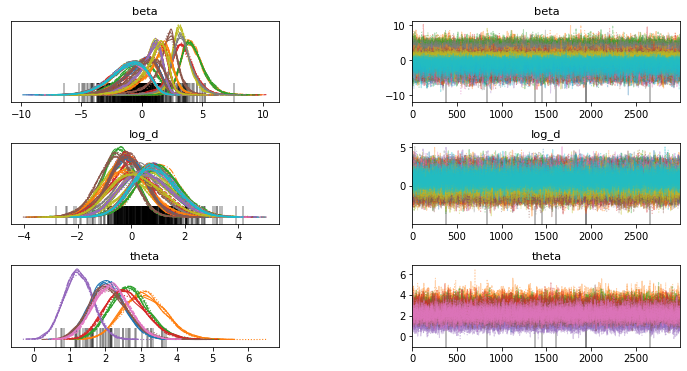

In [22]:
axes = az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

## Generate Posterior Predictive Samples

In [23]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

In [24]:
ppc_samples = predictive(jax.random.PRNGKey(1), num_cases=num_case, num_doctors=num_rad)

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

## Export Data


In [25]:
path = "idata_ppc_for_data%s_model%s.nc" % (DATA, MODEL)

idata_ppc.to_netcdf(path)

'idata_ppc_for_data0_model1.nc'

In [26]:
from google.colab import files

files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>